# Optimization of compute bound Python code 

## Layout:

* Foreword about optimization and profiling:
    - No optimisation without profiling
    - No benchmarking without tests
* Presentation of the example:
    - Square crystal: demonstration
    - Relaxed circular crystal: exercise
* `Python` version:
    - code with loops à la `FORTRAN`
    - Bottleneck search
* `Numpy` vectorized version:
    - Limits of vectorization: cache sizes
[...]

* `Numexpr` compiler for mathematical formula
    - Single and multi-threaded evaluation
    - Limits of `numexpr`
* `Numba`: just in time compilation of numerical code
    - Decoration of function
    - Type annotation
    - Limits of `numba`
* `Cython`: ahead of time compilation
    - `Cython` usage within `Jupyter`
    - Annotated compilation 
    - Single threaded performances
    - Parallelization with OpenMP
    - Mixing extensions with Python threads
* Conclusions:
    - Only addresses CPU-bound issues, not I/O issues
    - If your problem is still compute-bound, then move to GPU

## Definitions:
* In computer science, software **optimization** is the process of modifying a software system to make some aspect of it work more efficiently or use fewer resources.[[Wikipedia](https://en.wikipedia.org/wiki/Program_optimization)]
* In software engineering, software **profiling** is a form of dynamic program analysis that measures, for example, the space (memory) or time complexity of a program, the usage of particular instructions, or the frequency and duration of function calls. Most commonly, profiling information serves to aid program optimization, and more specifically, performance engineering. [[Wikipedia](https://en.wikipedia.org/wiki/Profiling_%28computer_programming%29)]
* Regression **testing** is re-running functional and non-functional tests to ensure that previously developed and tested software still performs after a change. If not, that would be called a regression. [[Wikipedia](https://en.wikipedia.org/wiki/Regression_testing)]

## Methodology:

1. **Make your algorithm work**, regardless how you implement it.
2. Make it right and ensure it is right before writing **non-regression tests**.
3. **Benchmark** it. 
4. If it fast enough, goto 9.
5. **Profile** it to see where most of the time is spent.
6. **Optimize** your code where most time is spent. 
7. **Check** non-regression tests are still passing:
   * Fast algorithms giving wrong answers are useless!
8. **Loop** to 3.
9. Your work is **done** and you deserve a beer

**Premature optimization is the root of all evil (or at least most of it) in programming.** *Donald Knuth*

## Profiling in Python

The standard library of *Python* contains the `cProfile` module which collects information about the running code. It is a *C* version of the `profile` module.

Profile results can be analyzed with the `pstats` module or exernal programs like [**RunSnakeRun**](http://www.vrplumber.com/programming/runsnakerun/), [**SnakeViz**](https://jiffyclub.github.io/snakeviz/) or [**kcachegrind**](https://kcachegrind.github.io/) (using [pyprof2calltree](https://pypi.org/project/pyprof2calltree/) converter). 

Profiling induces slow-down, it should be distinguished from *benchmarking* which measures the actual performances.

Here is the link to the official python documentation: https://docs.python.org/3/library/profile.html

In [1]:
import math, cProfile
prf = cProfile.Profile()
prf.enable() # Start of the profiled section:
size = 1000000; distance = 1; tth = []
for i in range(size):
    x_i = size//1000/1000
    y_i = size%1000/1000
    tth.append(math.atan2(math.sqrt(x_i**2 + y_i**2), distance))
prf.disable() #End of section:
prf.dump_stats("profile.log"); prf.print_stats(sort=1) # Save / display some results

         3000109 function calls in 0.850 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.618    0.618    0.849    0.849 <ipython-input-1-bd2ff54b70bf>:5(<module>)
  1000000    0.113    0.000    0.113    0.000 {built-in method math.atan2}
  1000000    0.065    0.000    0.065    0.000 {built-in method math.sqrt}
  1000000    0.053    0.000    0.053    0.000 {method 'append' of 'list' objects}
        5    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        5    0.000    0.000    0.849    0.170 interactiveshell.py:3293(run_code)
        5    0.000    0.000    0.000    0.000 codeop.py:132(__call__)
        5    0.000    0.000    0.000    0.000 contextlib.py:82(__init__)
       10    0.000    0.000    0.000    0.000 compilerop.py:138(extra_flags)
        5    0.000    0.000    0.000    0.000 hooks.py:103(__call__)
        5    0.000    0.000    0.000    0.000 contextlib.py:117(__exit__)
   

Example of visualization of the profiling with **runSnakeRun** or **SnakeViz**. Equivalent visualization is available from the other tools.

This is the typical way of using the Python profiler. Another way to use it is to invoque it when starting the process:

`python -m cProfile -o profile.log myscript.py`


In [2]:
#!snakeviz profile.log

# Jupyter magic functions for profiling

Line magics:

* `%time`: measure the time to run one statement/function call, once
* `%timeit`: measure in benchmarking mode (many repetitions, garbage collector disabled)
* `%prun`: run command within the profiler
* `%lprun`: run with the line-profiler active
* `%memit`: check for memory allocations
* `%mprun`: run with memory profile, line per line

All those functions can be used with `%%` to apply to the full cell instead of a single command.
    
Mind to ask for their help ... sometimes they have multiple options `%timeit?`

In [3]:
%timeit?

In [4]:
# Description of the system:
import os
import cpuinfo
if hasattr(os, 'shed_getaffinity'):  # Some Unix only
    # Get the number of cores the Python process has access to
    # This provides the number of cores requested in SLURM
    n_cpu = len(os.sched_getaffinity(0))
else:
    n_cpu = os.cpu_count()
n_total_cpu = os.cpu_count()
print(f"We can use {n_cpu} out of the {n_total_cpu} cores of the computer")
# Limit the number of cores we use to at most 8
n_cpu = min(8, n_cpu); print(f"We are using only {n_cpu} cores") 
for key, val in cpuinfo.get_cpu_info().items():
    if "cache_size" in key:
        print(key, val)

## Two-dimensional Laue function example

All this training is based on the same example: 2D diffraction from a finite size crystallite given by Laue function:

$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \exp \left [ 2 \pi i \left ( H n + K m \right ) \right ] \right| ^2 $$

This equation describes the scattering from square crystal:

- **N** is the number of unit cells of the crystal in both directions
- **n** and **m** are the indices of the unit-cell in each direction (**real space** coordinates),
- **H** and **K** are the continuous Miller indices (**reciprocal space** coordinates).

In [ ]:
import numpy as np
import cmath

def laue(N, H, K):
    """Laue formulae for a square crystal with N unit cells given H, K coordinate"""
    tmp = 0.0
    for n in range(N):  # loop and sum over unit-cells
        for m in range(N):
            tmp += cmath.exp(2j*np.pi*(H*n + K*m))
    return abs(tmp)**2

laue(N=32, H=0, K=4)

To build an image of the diffraction peak, the continuous Miller indices are sampled in the neighborhood of **H**, **K**:

- $h \in [H-0.5,H+0.5]$
- $k \in [K-0.5,K+0.5]$

With $oversampling * N$ samples on each direction, where:

- **N** is the number of unit cells of the crystal in both directions
- **oversampling** defines how much points are needed to describe a single Laue fringe (2 = Nyquist frequency)

![bragg peak](square_crystal_bragg_peak.png)

This example is derived from: https://journals.iucr.org/j/issues/2019/04/00/gj5229/gj5229.pdf

In [5]:
%matplotlib inline 
# This is for plotting
import math
import cmath
import numpy as np
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm

In [6]:
# Some constants valid for all calculation
# Miller index of reflection
H = 0 
# Miller index of reflection
K = 4 
# Number of unit cells per direction
N = 32 
# Defines how much points are needed to describe a single Laue fringe (2 = Nyquist frequency)
oversampling = 3

# Generate real and reciprocal space coordinates
n = np.arange(N)
m = np.arange(N)
h = np.arange(H-0.5, H+0.5, 1./(oversampling*N))
k = np.arange(K-0.5, K+0.5, 1./(oversampling*N))

In [7]:
def Laue_python(N, h, k):
    result = np.zeros((h.size, k.size))
    for i_h, v_h in enumerate(h):  # loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0.0
            for n in range(N):  # loop and sum over unit-cells
                for m in range(N):
                    tmp += cmath.exp(2j*np.pi*(v_h*n + v_k*m))
            result[i_h, i_k] = abs(tmp)**2
    return result

#Compute
%time square_intensity = Laue_python(N, h, k)

CPU times: user 4.95 s, sys: 2.82 ms, total: 4.95 s
Wall time: 4.95 s


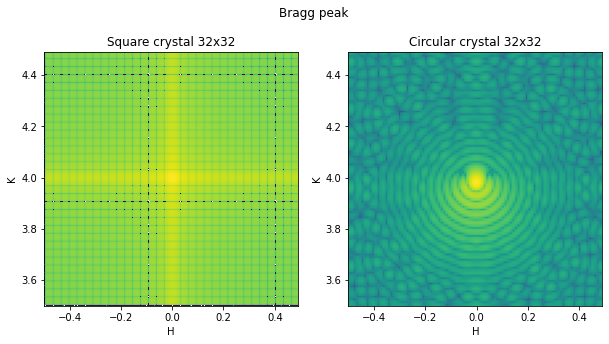

In [7]:
# Visualization of the reference images
fig, ax = subplots(1,2, figsize=(10,5))
fig.suptitle("Bragg peak")
ax[0].imshow(np.load("reference_sq.npy").T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax[0].set_xlabel('H')
ax[0].set_ylabel('K')
ax[0].set_title(f"Square crystal {N}x{N}")
ax[1].imshow(np.load("reference_ci.npy").T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax[1].set_xlabel('H')
ax[1].set_ylabel('K')
ax[1].set_title(f"Circular crystal {N}x{N}")
pass

### Validation of optimization

Code optimization should always be performed with some tests to ensure the speed-up obtained is not degrading the numerical quality !

In [9]:
def validate_sq(result):
    "Return the error value"
    reference = np.load("reference_sq.npy")
    return abs(reference-result).max()/reference.max()

def validate_ci(result):
    "Return the error value (for exercises)"
    reference = np.load("reference_ci.npy")
    return abs(np.array(reference)-result).max()/reference.max()

def display(result):
    "Display the array"
    fig, ax = subplots()
    fig.suptitle("Bragg peak")
    ax.imshow(result.T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
    ax.set_xlabel('H');ax.set_ylabel('K')
    ax.set_title(f"Crystal {N}x{N}")
    
print("Error measured:", validate_sq(square_intensity))  # Validation of the result:
perf_sq_python = %timeit -o Laue_python(N, h, k)      # Measure performances of the Python implementation

Error measured: 4.218847493575595e-15
4.86 s ± 57.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# Run a function in the Python profiler ...
%prun -D square.log Laue_python(N, h, k)

 
*** Profile stats marshalled to file 'square.log'. 


In [11]:
# Line profiler:
%load_ext line_profiler
%lprun -f Laue_python Laue_python(N, h, k)

In [12]:
#Memory profiler
%load_ext memory_profiler
%memit Laue_python(N, h, k)

peak memory: 126.38 MiB, increment: 0.22 MiB


## Exercise


### Circular crystal

Let's first consider the case of a **circular** crystal rather than a square:

1. Write a function generating the diffraction from a **circular** 2D crystal without strain.
   The previous formula then becomes:

   $$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \Omega \left (n,m \right ) \exp \left [ 2 \pi i \left ( H n + K m \right ) \right ] \right | ^2$$

   With $R=N/2$ the radius of the disk, the support function $\Omega\left (n,m \right )$ is defined as: 
     * $ \Omega \left (n,m \right ) = 0$  where $(n-N/2)^2+(m-N/2)^2>(N/2)^2$
     * $ \Omega \left (n,m \right ) = 1$  where $(n-N/2)^2+(m-N/2)^2 \leq (N/2)^2$


2. How do these modifications affect the result? the execution speed?

In [42]:
# Miller index of reflection
H = 0
# Miller index of reflection
K = 4
# Number of unit cells per direction
N = 32
# Defines how much points are needed to describe a single Laue fringe (2 = Nyquist frequency)
oversampling = 3

# Radius of the crystal
R = N/2

# Generate real and reciprocal space coordinates
n = np.arange(N)
m = np.arange(N)
h = np.arange(H-0.5, H+0.5, 1./(oversampling*N))
k = np.arange(K-0.5, K+0.5, 1./(oversampling*N))

In [ ]:
def Circ_python_1(N, h, k):
    pass

In [46]:
%time intensity_circle = Circ_python_1(N, h, k)
print("Error:", validate_ci(intensity_circle))
display(intensity_circle)

### Strained circular crystal

Let's consider the case where the circular crystal atoms are not perfectly ordered (**strain**).

**Strain** implies that unit-cells are shifted from their regular position according to $\overrightarrow{r'_i} = \overrightarrow{r_i} + \overrightarrow{\Delta r_i}$, where $\overrightarrow{\Delta r_i}$ is the displacement for the cell *i*.
For the case of a circular crystal, a function describing a progressive dilatation when moving from the center towards the periphery. 
It can be written:

$$  \overrightarrow{\Delta r}(\overrightarrow{r}) = e_{0} \overrightarrow{r} (1 + tanh(\frac{r-R}{w})) $$
where:

- $\overrightarrow{\Delta r}(\overrightarrow{r})$ is the displacement of the unit-cell located at a distance $r$ from the crystal center,
- $R=N/2$ is the radius of the disk,
- $e_0$ is the maximum strain,
- $w$ is a parameter describing the width of the displacement profile (for small values of $w$ the strain is confined at the periphery of the crystal, whereas large values also affect the interior of the crystal).

The previous formula then becomes:

$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \Omega \left (n,m \right ) \exp \left \{ 2 \pi i \left [ H \left (n + \Delta n_{n,m}\right )+ K \left (m + \Delta m_{n,m}\right ) \right ] \right \} \right | ^2$$

**Exercise**:

1. Modify the function to take into account the displacement induced by the strain.
2. How do thess modifications affect the result? the execution speed? Store the timimg in `perf_ci_python`

In [35]:
# Miller index of reflection
H = 0 
# Miller index of reflection
K = 4 
# Number of unit cells per direction
N = 32 
# Defines how much points are needed to describe a single Laue fringe (2 = Nyquist frequency)
oversampling = 3

# Maximum strain at surface
e0 = 0.01 
# Width of the strain profile below the surface
w = 5.

# Generate real and reciprocal space coordinates
n = np.arange(N)
m = np.arange(N)
h = np.arange(H-0.5, H+0.5, 1./(oversampling*N))
k = np.arange(K-0.5, K+0.5, 1./(oversampling*N))

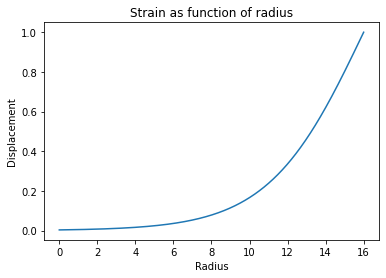

In [36]:
# Displacement of atoms as function of the radius
def delta(radius, crystal_radius, strain_width):
    """Displacement of atoms as function of the radius"""
    return 1 + np.tanh((radius - crystal_radius) / strain_width)

fig, ax = subplots()
x = np.linspace(0, N/2, 1000)
ax.plot(x, delta(x, N/2, w))
ax.set_xlabel("Radius")
ax.set_ylabel("Displacement")
t = ax.set_title("Strain as function of radius")

In [81]:
def Circ_python(N, h, k):
    pass

In [ ]:
%time intensity_circle = Circ_python(N, h, k)
display(intensity_circle)
perf_ci_python = %timeit -o Circ_python(N, h, k)

**Exercise:** Profile your strained crystal diffraction with `%prun` and `%lprun` and `%memit`.

In [17]:
%prun -D circle.log Circ_python(N, h, k)

 
*** Profile stats marshalled to file 'circle.log'. 


In [18]:
%lprun -f Circ_python Circ_python(N, h, k)

In [19]:
%memit Circ_python(N, h, k)

peak memory: 132.70 MiB, increment: 0.09 MiB


## Optimization with `NumPy`

Python is a dynamic language and is known to be pretty inefficient when looping over large datasets.
The `numpy` library offers vectorial notation which avoids those loops.

### Square crystal implemented with `NumPy`

This is how this code looks like once fully vectorized with `NumPy`:

In [20]:
def Laue_numpy(N, h, k):
    h = h.reshape(-1, 1, 1, 1)
    k = k.reshape(1, -1, 1, 1)
    n = np.arange(N).reshape(1, 1, -1, 1)
    m = np.arange(N).reshape(1, 1, 1, -1)
    return np.abs(
        np.sum(
            np.exp(2j * np.pi * (h*n + k*m)),
            axis=(2, 3),
        )
    )**2

In [58]:
# Compute and check error
%time intensity = Laue_numpy(N, h, k)
print("Error:", validate_sq(intensity))
perf_sq_numpy = %timeit -o Laue_numpy(N, h, k)

CPU times: user 321 ms, sys: 24 ms, total: 345 ms
Wall time: 344 ms
Error: 0.0
333 ms ± 455 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


The first striking observation is that the code is much more concise: it can fit in a single line.

It is also much clearer being shorter and with a syntax similar to the provided formula:

$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \exp \left [ 2 \pi i \left ( H n + K m \right ) \right ] \right| ^2 $$

Lines 2-5 add new (empty) dimensions to the input arrays. With this transformation the calculation of `h*n + k*m` actually returns a 4-dimensional array. This important feature of NumPy is known as [**broadcasting**](https://numpy.org/doc/stable/reference/ufuncs.html#broadcasting). 

The exponential then operates on all cells of this array.

The sum over the real-space coordinates is performed using numpy's `sum()` function: the `axis=(2, 3)` argument designates the fact that the summation has to be performed over the last two dimensions of the array that contain the real space variables.

Besides the cleaner syntax, this implementation is also much faster than Python code.

In [46]:
# Broadcasing example
a = np.array([1, 2, 3])
b = a.reshape(-1, 1)
print('a =', a)
print('b =', b)
print('a*b =', a*b)

a = [1 2 3]
b = [[1]
 [2]
 [3]]
a*b = [[1 2 3]
 [2 4 6]
 [3 6 9]]


### Exercise

1. Implement the strained crystal diffraction using `NumPy` ([Documentation](https://numpy.org/doc/stable/reference/index.html)).
2. Profile the code and store the timings in `perf_ci_numpy`.

In [22]:
def Circ_numpy(N, h, k):
    pass

In [46]:
#Compute and check error
%time intensity = Circ_numpy(N, h, k)
print("Error:", validate_ci(intensity))
perf_ci_numpy = %timeit -o Circ_numpy(N, h, k)

### Limits of `numpy`'s vectorization

When calculating expression like `a+2*b+5*c+a*b`, each individual operation creates a new temporary array where all results of each binary operation are stored. This can be an issue when the number of operands is large and that those temporary arrays are larger than the cache of the processor. Those temporary arrays need to go back to central memory before starting next operation and this is bad for performances.

In [23]:
#Importance of the cache:
def tmp_numpy(N, h, k):
    h = h.reshape(-1, 1, 1, 1)
    k = k.reshape(1, -1, 1, 1)
    n = np.arange(N).reshape(1, 1, -1, 1)
    m = np.arange(N).reshape(1, 1, 1, -1)
    return np.exp(2j*np.pi*(h*n + k*m))
print(f"Size of the intermediate array: {tmp_numpy(N,h,k).nbytes/2**20:.2f} MiB")

Size of the intermediate array: 144.00 MiB


In [24]:
%memit Laue_numpy(N, h, k)

peak memory: 397.38 MiB, increment: 264.00 MiB


## Multi-threading in Python

Threads are lightweight processes which have all access to the process memory and have some own local memory space. 
It looks like a good idea to have different threads performing some work in parallel to use the multi-cores of our modern processors. 

Python offers access to threads via the `threading` library, and offers some more convenient tools like the `ThreadPool` from `multiprocessing.pool`, able to apply the same function to a set of different inputs. 

In [25]:
from multiprocessing.pool import ThreadPool, Pool
from itertools import product

def Laue_mt(N, h, k):
    n = np.arange(N).reshape(-1, 1)
    m = np.arange(N).reshape(1, -1)
    def Laue_st(hi, ki):
        return np.abs(np.exp(2j*np.pi*(hi*n + ki*m)).sum())**2
    with ThreadPool(n_cpu) as pool:
        tmp = pool.starmap(Laue_st, product(h, k))
    return np.array(tmp).reshape(h.size, k.size)

In [ ]:
%time intensity = Laue_mt(N, h, k)
print("Error:", validate_sq(intensity))
perf_sq_mt = %timeit -o Laue_mt(N, h, k)
print(f"Speed-up {perf_sq_numpy.best/perf_sq_mt.best:6.3f}x over {n_cpu} processes")

By running `htop` during the execution of the previous cell, one validates that many cores are used simultaneously but the execution time is much longer. The performances are ~50% worse than without threads!
All threads are **fighting for the Global Interpreter Lock (GIL)**, i.e., they are all waiting for the GIL to be allowed to run a bit of code.
This explains why, by going parallel, it is slower (with pure Python code).

### Introduction to the GIL

Indeed, using threads looks like a good idea but turns out to be more complicated than expected.
Having multiple threads accessing to the same Python object, possibly modifying them inplace, is dangerous. 
This is why developers of Python introduced the GIL (Global Intepreter Lock) which prevents multiple Python objects from being accessed simulaneously.

The GIL is at the core of C-Python but other implementations of Python do not suffer from the GIL: PyPy, Jython or IronPython are some examples. 
For now, there is no reason to hope this will change in the future. Just learn to live with the GIL!

There are two ways to work-around the GIL:
1. Using separated processes
2. Use GIL-free sections

#### 1. Using separated processes
   Processes have distinct memory spaces and can run simultaneously without interfering. There is a `ProcessPool` 
   which works like the `ThreadPool` except that workers are separated processes. 
   The drawback of this method is that both the program, operands and the result should be sent to the worker and back.
   This requires them to be **serialized** and fully self-consistent. For example the shared variables *n* and *m* are no more allowed. 

The next cell presents an example of implementation:

In [27]:
class LaueSP:
    def __init__(self, N):
        self.n = np.arange(N).reshape(1, -1)
        self.m = np.arange(N).reshape(-1, 1)
    def __call__(self, h, k):
        return np.abs(np.exp(2j*np.pi*(h*self.n + k*self.m)).sum())**2

def Laue_mp(N, h, k):
    with Pool(n_cpu) as pool:
        laue = LaueSP(N)
        tmp = pool.starmap(laue, product(h, k))     
    return np.array(tmp).reshape(h.size, k.size)

In [28]:
%time intensity = Laue_mp(N, h, k)
print("Error:", validate_sq(intensity)) #Compute and check error
perf_sq_mt = %timeit -o Laue_mp(N, h, k)
print(f"Speed-up {perf_sq_numpy.best/perf_sq_mt.best:6.3f}x over {n_cpu} processes")

CPU times: user 22.7 ms, sys: 48 ms, total: 70.7 ms
Wall time: 138 ms
Error: 1.1102230246251565e-16
140 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Speed-up  2.412x over 8 processes


A class instance *laue* has to be used to ship the shared variable ($n$, $m$) to other processes, making the code a bit harder to read for people not used to object oriented programming (OOP).

Moreover, the speed-up obtained (3) is far from the resources consumed (8), this is due to the communication overhead.

#### 2. Use threads with section which are all **GIL-free**

   Next section will present three tools which are all compilers able to produce parallel code which is actually run using all cores of your computer.
   * `NumExp`: Fast numerical expression evaluator
   * `Numba`: JIT Python compiler
   * `Cython`: C-extensions for Python
   
Several other tool exists (`Pytran`, `Transonic`, ...) but won't be presented.

## `NumExpr` is a fast numerical expression evaluator for `NumPy`.

It works best for evaluating large numerical expressions on arrays which do not fit into cache. The speed-up is typically of the order of 4-8x (may be limited by the number of cores since `numexpr` uses all cores).

In [29]:
import numexpr as ne
ne.set_num_threads(n_cpu)  # Limit the number of threads to be used

a = np.arange(10)
ne.evaluate("sin(a)**2 + cos(a)**2")

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

How does `NumExpr` work:
1. Parse the mathematical expression 
2. Compile it in the Virtual Machine
2. Split data into chunks (4096 bytes: cache friendly). Broadcasting is handled as well.
3. Chunks can be processed in multiple threads

In [30]:
# How does NumExpr actually work ...
nex = ne.NumExpr("sin(a)**2 + cos(a)**2")
print(ne.disassemble(nex))

[(b'func_ddn', b't2', b'r1[a]', 1), (b'mul_ddd', b't2', b't2', b't2'), (b'func_ddn', b'r0', b'r1[a]', 2), (b'mul_ddd', b'r0', b'r0', b'r0'), (b'add_ddd', b'r0', b't2', b'r0')]


### Square crystal implemented with `NumExpr`

* Only the complex exponential part is implemented in `NumExpr`.
* `NumExpr` implements efficiently the broadcast of data.
* Reductions (sum) exists but it is not faster than `NumPy`.

In [80]:
def Laue_numexpr(N, h, k):
    h = h.reshape(-1, 1, 1, 1)
    k = k.reshape(1, -1, 1, 1)
    n = np.arange(N).reshape(1, 1, -1, 1)
    m = np.arange(N).reshape(1, 1, 1, -1)
    j2pi = np.pi*2j
    tmp = ne.evaluate("exp(j2pi*(h*n + k*m))")
    return np.abs(np.sum(tmp, axis=(2, 3)))**2

#Compute and check error
intensity = Laue_numexpr(N, h, k)
print("Error:", validate_sq(intensity))
perf_sq_numexpr = %timeit -o Laue_numexpr(N, h, k)
%memit Laue_numexpr(N, h, k)

Error: 0.0
75.4 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
peak memory: 278.84 MiB, increment: 144.00 MiB


In [32]:
# Full NumExpr version ... not faster.
def Laue_numexpr2(N, h, k):
    h = h.reshape(-1, 1, 1, 1)
    k = k.reshape(1, -1, 1, 1)
    n = np.arange(N).reshape(1, 1, -1, 1)
    m = np.arange(N).reshape(1, 1, 1, -1)
    j2pi = np.pi*2j
    tmp = ne.evaluate("exp(j2pi*(h*n + k*m))")
    tmp.shape = h.size, k.size, -1
    return abs(ne.evaluate("sum(tmp, axis=2)"))**2

#Compute and check error
intensity = Laue_numexpr2(N, h, k)
print("Error:", validate_sq(intensity))
perf_sq_numexpr2 = %timeit -o Laue_numexpr2(N, h, k)
%memit Laue_numexpr2(N, h, k)

Error: 4.218847493575595e-15
77 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
peak memory: 278.84 MiB, increment: 144.00 MiB


### Exercise

1. Implement the strained crystal diffraction using `NumExpr` ([User Guide](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/user_guide.html)).
2. Profile the code and store the timings in `perf_ci_numexpr`.

In [33]:
def Circ_numexpr(N, h, k):
    pass

In [ ]:
%time  intensity = Circ_numexpr(N, h, k)
print("Error:", validate_ci(intensity))
perf_ci_numexpr = %timeit -o Circ_numexpr(N, h, k)

### Limits of `NumExpr`
* Limited to mathematical functions
* Limited to element-wise evaluation (reduction is under development)

## `Numba`, a high performance Python compiler
`Numba` is an open source, **Just In Time** compiler that translates a subset of `Python` and `NumPy` code into fast machine code using the `LLVM` compiler library.

`Numba` provides a `jit` decorator to indicate the function should be compiled. It usually performs better on explicit loops but accepts most of the `NumPy` constructions. The `jit` decorator takes those options:
* signature of the function
* `nogil=True`: the function should contains not more Python construct after compilation
* `nopython=True`: raises an exception when Python construct remains
* `parallel=True`: enables parallel excution with `numba.prange` instead of `range`. Requires `nogil` and `nopython`

In [34]:
import numba as nb
nb.set_num_threads(n_cpu)  # Limit the number of cores to be used

In [35]:
@nb.jit
def test_one(a):
    result = np.zeros(a.shape)
    for i in range(a.size):
        result[i] = np.cos(a[i])**2 + np.sin(a[i])**2
    return result

a = np.arange(10)
%time test_one(a)
%timeit test_one(a)
test_one(a)

In [ ]:
# Get the assembly code
for key, value in test_one.inspect_asm().items():
    print("Signature:", key)
    print("Machine code:\n",value)

### Square crystal implemented with `Numba`

In [89]:
@nb.jit(parallel=True)
def Laue_numba(N, h, k):
    result = np.zeros((h.size, k.size), dtype=np.float64)
    for i in nb.prange(h.size):  # loop over the reciprocal space coordinates
        for j in range(k.size):
            tmp = 0j
            for n in range(N):  # loop and sum over unit-cells
                for m in range(N):
                    tmp +=  cmath.exp(2j*np.pi*(h[i]*n + k[j]*m))
            result[i, j] = abs(tmp)**2
    return result

#Compute and check error
%time intensity = Laue_numba(N, h, k)
print("Error:", validate_sq(intensity))

CPU times: user 1.1 s, sys: 8.58 ms, total: 1.1 s
Wall time: 906 ms
Error: 4.218847493575595e-15


In [38]:
perf_sq_numba = %timeit -o Laue_numba(N, h, k)

In [39]:
%memit Laue_numba(N, h, k)

### Exercise

1. Implement the strained crystal diffraction using `Numba` ([Documentation](https://numba.readthedocs.io/)).
2. Profile the code and store the timings in `perf_ci_numba`.

In [40]:
@nb.jit(parallel=True)
def Circ_numba(N, h, k):
    pass

In [ ]:
%time intensity = Circ_numba(N, h, k)
print("Error:", validate_ci(intensity))
perf_ci_numba = %timeit -o  Circ_numba(N, h, k)

### Limits of `Numba`
`Numba` being a JIT compiler, it requires the compiler `LLVM-lite` to be installed and configured on every single node.

The second drawback is the JIT: the compilation will be performed for the first execution of a session and if it runs on a cluster, the compilation will occur on every node. Numba is not `multi-processing` friendly.

Finally the support for multi-threading in classes looks brittle, at least when evaluated.

## Cython: C-extensions for Python

Static, ahead-of-time compiler for Python: compiles Python code into C-extensions (or C++ if you wish).

Normal Python code gets usually 30% speed-up but for numerical kernels, native C-speed is achievable easily.
To get substential speed-up, one need to declare most variables and explicitly write loops. 

The methodology is pretty similar to `numba`:
1. Write the code with loops
2. Use the `cython -a` to annotate the code to highlight potential hot-spots, in yellow.
3. Declare variables which are not infered with `cdef` and the proper type
4. Isolate the numerical kernel and replace numpy functions with the ones provided by the `libc` or `libm` which are garanteed to be GIL-free.

In [41]:
import os

os.environ["OMP_NUM_THREADS"] = str(n_cpu)
# This enables the %cython mode
%load_ext Cython

### Square crystal implemented with `Cython`

In [42]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp -a
#cython: embedsignature=True, language_level=3, binding=True
#cython: boundscheck=False, wraparound=False, cdivision=True, initializedcheck=False,
## This is for developping:
## cython: profile=True, warn.undeclared=True, warn.unused=True, warn.unused_result=False, warn.unused_arg=True

import numpy as np
from cython.parallel import prange
from libc.complex cimport cabs, cexp
    
def Laue_cython(long[::1] n, 
                long[::1] m, 
                double[::1] h, 
                double[::1] k):
    cdef:
        double[:, ::1] result
        double complex tmp, two_j_pi
        int i_h, i_k, i_m, i_n, h_size, k_size, n_size, m_size
        
    two_j_pi = np.pi*2j
    h_size = h.shape[0]
    k_size = k.shape[0]
    n_size = n.shape[0]
    m_size = m.shape[0]
    result = np.zeros((h_size, k_size))
    
    for i_h in prange(h_size, nogil=True):  # loop over the reciprocal space coordinates
        for i_k in range(k_size):
            tmp = 0.0
            for i_n in range(n_size):  # loop and sum over unit-cells
                for i_m in range(m_size):
                    tmp += cexp(two_j_pi*(h[i_h]*n[i_n] + k[i_k]*m[i_m]))
            result[i_h, i_k] += cabs(tmp)**2
    return np.asarray(result)

In [43]:
#Compute and check error
%time intensity = Laue_cython(n, m, h, k)
print("Error:", validate_sq(intensity))
perf_sq_cython = %timeit -o Laue_cython(n, m, h, k)

CPU times: user 540 ms, sys: 3.77 ms, total: 544 ms
Wall time: 67 ms
Error: 4.218847493575595e-15
42.7 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Exercise

1. Implement the strained crystal diffraction using `Cython` ([Documentation](http://docs.cython.org/en/latest/)).

2. Profile the code and store the timings in `perf_ci_cython`.

In [ ]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp -a
#%%cython -a
#cython: embedsignature=True, language_level=3, binding=True
# cython: boundscheck=False, wraparound=False, cdivision=True, initializedcheck=False,
## This is for developping:
## cython: profile=True, warn.undeclared=True, warn.unused=True, warn.unused_result=False, warn.unused_arg=True

import numpy as np
from cython.parallel import prange
from libc.math cimport sqrt, pi, tanh
from libc.complex cimport cabs, cexp
    
def Circ_cython(long[::1] n, 
                long[::1] m, 
                double[::1] h, 
                double[::1] k,
                double e0,
                double w):
    pass

In [45]:
#Compute and check error
%time intensity = Circ_cython(n, m, h, k, e0, w)
print("Error:", validate_ci(intensity))
perf_ci_cython = %timeit -o Circ_cython(n, m, h, k, e0, w)

CPU times: user 876 ms, sys: 123 µs, total: 876 ms
Wall time: 105 ms
Error: 3.3097742436391504e-15
72.7 ms ± 405 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Limits of `Cython`

* The learning curve for `Cython` is steaper than that of `numba` since it targets C/C++ as intermediate language.
* Distribution of compiled extensions can be an issue. 
* Distribution of source code (C or C++) requires the user to install a compiler (rarely on consumer targeted operating systems like Windows & MacOS).
* Compiler features depend a lot on the operating system: For instance MacOS removed the support for OpenMP.
* Issues about software distribution are addressed in the software engineering training course.

The issue about OpenMP not being supported in some environments can be worked around using a `ThreadPool` in Python and a `nogil` section in Cython:

In [46]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp -a
#%%cython -a
#cython: embedsignature=True, language_level=3, binding=True
# cython: boundscheck=False, wraparound=False, cdivision=True, initializedcheck=False,
## This is for developping:
## cython: profile=True, warn.undeclared=True, warn.unused=True, warn.unused_result=False, warn.unused_arg=True

import numpy as np
from cython.parallel import prange
from libc.math cimport sqrt, pi, tanh
from libc.complex cimport cabs, cexp
    
def Circ_cython(long[::1] n, 
                long[::1] m, 
                double[::1] h, 
                double[::1] k,
                double e0,
                double w):
    cdef:
        double[:, ::1] result
        double N_2, p_n, p_m, strain, radius, n_v, m_v
        double complex tmp, two_j_pi,  value
        int i_h, i_k, i_m, i_n, h_size, k_size, n_size, m_size
        
    two_j_pi = np.pi*2j
    h_size = h.shape[0]
    k_size = k.shape[0]
    n_size = n.shape[0]
    m_size = m.shape[0]
    result = np.zeros((h_size, k_size))
    N_2 = n_size / 2.0
    for i_h in prange(h_size, nogil=True):  # loop over the reciprocal space coordinates
        for i_k in range(k_size):
            tmp = 0.0
            for i_n in range(n_size):#loop and sum over unit-cells
                n_v = n[i_n]
                for i_m in range(m_size):
                    m_v = m[i_m]
                    radius = sqrt((n_v - N_2)** 2 + (m_v - N_2)** 2)
                    if (radius > (N_2)):
                        value = 0.0
                    else:
                        strain = e0 * (1.0 + tanh((radius-N_2)/w))
                        p_n = i_n + strain*(i_n - N_2)
                        p_m = i_m + strain*(i_m - N_2)
                        value = cexp(2j*pi*(h[i_h]*p_n + k[i_k]*p_m))
                    tmp +=  value
            result[i_h, i_k] += cabs(tmp)**2
    return np.asarray(result)


In [45]:
#Compute and check error
%time intensity = Circ_cython(n, m, h, k, e0, w)
print("Error:", validate_ci(intensity))
perf_ci_cython = %timeit -o Circ_cython(n, m, h, k, e0, w)

CPU times: user 876 ms, sys: 123 µs, total: 876 ms
Wall time: 105 ms
Error: 3.3097742436391504e-15
72.7 ms ± 405 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Limits of `Cython`

* The learning curve for `Cython` is steaper than that of `numba` since it targets C/C++ as intermediate language.
* Distribution of compiled extensions can be an issue. 
* Distribution of source code (C or C++) requires the user to install a compiler (rarely on consumer targeted operating systems like Windows & MacOS).
* Compiler features depend a lot on the operating system: For instance MacOS removed the support for OpenMP.
* Issues about software distribution are addressed in the software engineering training course.

The issue about OpenMP not being supported in some environments can be worked around using a `ThreadPool` in Python and a `nogil` section in Cython:

In [46]:
%%cython -a
#cython: embedsignature=True, language_level=3, binding=True
#cython: boundscheck=False, wraparound=False, cdivision=True, initializedcheck=False,
## This is for developping:
## cython: profile=True, warn.undeclared=True, warn.unused=True, warn.unused_result=False, warn.unused_arg=True

from libc.math cimport pi
from libc.complex cimport cabs, cexp

    
def Laue_nogil(long[::1] n, 
               long[::1] m, 
               double h, 
               double k):
    cdef:
        double result
        double complex tmp, two_j_pi
        int i_m, i_n, n_size, m_size
        
    
    n_size = n.shape[0]
    m_size = m.shape[0]
    with nogil:
        two_j_pi = pi*2j    
        tmp = 0.0
        for i_n in range(n_size):  # loop and sum over unit-cells
            for i_m in range(m_size):
                tmp += cexp(two_j_pi*(h*n[i_n] + k*m[i_m]))
        result = cabs(tmp)**2
    return result

In [47]:
def Laue_pool(n, m, h, k):
    def local_Laue(i, j):
        return Laue_nogil(n, m, i, j)
    with ThreadPool(n_cpu) as pool:
        res = pool.starmap(local_Laue, product(h, k))
    return np.array(res).reshape(h.size, k.size)

#Compute and check error
%time intensity = Laue_pool(n, m, h, k)
print("Error:", validate_sq(intensity))
perf_sq_pool = %timeit -o Laue_cython(n, m, h, k) 

CPU times: user 512 ms, sys: 0 ns, total: 512 ms
Wall time: 81.6 ms
Error: 4.218847493575595e-15
46.1 ms ± 6.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Other players in the game of optimizing Python code ...

This tutorial demonstrated 4 ways of optimizing:
* Vectorization with `NumPy`
* Numerical kernel evaluation with `NumExpr`
* Just In Time (JIT)-compilation with `Numba`
* Ahead Of Time (AOT)-compilation with `Cython`

There are several other ways to optimize code:
* `Pythran` which is a Python to C++ compiler (with parallel and SIMD vectorization)
* `Transonic` which is a wrapper over the different methods exposed here
* Write Fortran code and bind it with `F2py`
* Write C++ code and bind it with Cython, Boost, pybind11, ...
* Write C code and bind it with Cython, ctypes, swig, ...

Last but not least, the best way to optimize the code is to use the proper algorithm. 
In this example, the diffraction of the square crystal can be calculated using a FFT.

### Use the right algorithm
The best way to optimize the code is to use the proper algorithm. In this example, the diffraction of the square crystal can be calculated using a FFT:

In [48]:
def Laue_fft(N, h, k):
    support = np.zeros([h.size,k.size]) #create a support function padded with 0s
    support[0:N, 0:N]=1 #the first N values
    return np.fft.fftshift(abs(np.fft.fft2(support))**2)

%time intensity = Laue_fft(N, h, k)
print("Error:", validate_sq(intensity))
perf_sq_fft = %timeit -o Laue_fft(N, h, k)

Unfortunately, the `FFT` approach does not work for strained crystals.

## Conclusions

Within the Python ecosystem, the `NumPy` library is the *de facto* standard when it comes to scientific
computing. As long as the algorithms are properly vectorized and the memory is large enough to store
the arrays, it allows to reach high computational performances while keeping a clean and simple code,
close to mathematical notation. Used in combination with the `NumExpr` library, simple `NumPy` code
can benefit from multi-core CPUs as well as optimized memory management, with very little code
modification.

In the case where it is not possible to vectorize the algorithms, or when increased performances are
critical, one must make use of compilers that translate Python code into statically-typed code that also
provide an improved support of multi-core architectures. We have shown that `Numba` and `Cython` in
general exhibit very close performances and, given the heavier syntax of `Cython`, `Numba` is easier to
implement. `Cython`, on the other hand, allows to access more advanced options regarding thread and
memory management.

### Summary of the execution runtime

In [49]:
print("Runtime   Square (ms)  Speed-up (x)")
ref = perf_sq_numpy.best
print(f"Python    {1000*perf_sq_python.best:6.1f} ms   {ref/perf_sq_python.best:6.3f}x")
print(f"Numpy     {1000*perf_sq_numpy.best:6.1f} ms   {ref/perf_sq_numpy.best:6.3f}x")
print(f"NumExpr   {1000*perf_sq_numexpr.best:6.1f} ms   {ref/perf_sq_numexpr.best:6.3f}x")
print(f"Numba     {1000*perf_sq_numba.best:6.1f} ms   {ref/perf_sq_numba.best:6.3f}x")
print(f"Cython    {1000*perf_sq_cython.best:6.1f} ms   {ref/perf_sq_cython.best:6.3f}x")
print(f"Pool      {1000*perf_sq_pool.best:6.1f} ms   {ref/perf_sq_pool.best:6.3f}x")
print(f"FFT       {1000*perf_sq_fft.best:6.1f} ms   {ref/perf_sq_fft.best:6.1f}x")

Runtime   Square (ms)  Speed-up (x)
Python    4761.6 ms    0.070x
Numpy      332.5 ms    1.000x
NumExpr     75.1 ms    4.427x
Numba       51.6 ms    6.447x
Cython      42.3 ms    7.858x
Pool        42.2 ms    7.873x
FFT          0.3 ms   1151.4x


In [50]:
print("Runtime    Circle (ms)  Speed-up (x)")
ref = perf_ci_numpy.best
print(f"Python  {1000*perf_ci_python.best:8.1f} ms  {ref/perf_ci_python.best:6.3f}x")
print(f"Numpy   {1000*perf_ci_numpy.best:8.1f} ms  {ref/perf_ci_numpy.best:6.3f}x")
print(f"NumExpr {1000*perf_ci_numexpr.best:8.1f} ms  {ref/perf_ci_numexpr.best:6.3f}x")
print(f"Numba   {1000*perf_ci_numba.best:8.1f} ms  {ref/perf_ci_numba.best:6.3f}x")
print(f"Cython  {1000*perf_ci_cython.best:8.1f} ms  {ref/perf_ci_cython.best:6.3f}x")
# print(f"Pool    {1000*perf_sq_pool.best:8.1f} ms  {np.NaN:6.3f}x")

Runtime    Circle (ms)  Speed-up (x)
Python    4975.9 ms   0.078x
Numpy      389.7 ms   1.000x
NumExpr     85.6 ms   4.552x
Numba       91.9 ms   4.241x
Cython      72.1 ms   5.404x
